# Identifying Fraudulent Activity

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).

These are the tasks you are asked to do:
1. For each user, determine their country based on the IP address
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model
3. Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
4. Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

# Data Description

- **user_id:** Id of the user. Unique by user
- **signup_time:** the time when the user created her account (GMT time)
- **purchase_time:** the time when the user bought the item (GMT time)
- **purchase_value:** the cost of the item purchased (USD)
- **device_id:** the device id. You can assume that it is unique by device. I.e., same device ID means that the same physical device was used for the transaction
- **source:** user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser)
- **browser:** the browser used by the user
- **sex:** user sex: Male/Female
- **age:** user age
- **ip_address:** user numeric ip address
- **class:** this is what we are trying to predict: whether the activity was fraudulent (1) or not (0)

# Navigation
1. [Initial Exploration](#Initial)
2. Case Study Questions
    1. [Determine User Country](#Country)
    2. [Model to Predict Fraud](#Model)
        - [Feature Engineering](#Engineering)
        - [Modeling](#Modeling)
    3. [Model Explanation](#Explanation)
    4. [Using the Model in Production](#Production)
3. [Conclusion](#Conclusion)

<a name='Initial'></a>
# Initial Exploration

In [ ]:
!pip install category_encoders
!pip install pdpbox

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox import info_plots

In [ ]:
df =  pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked/main/CSVs/Fraud_Data.csv?token=ALJ4RG42JZZOL5UNUW7Y5PK74J3TS')

df['ip_address'] = df['ip_address'].astype(int)
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

print(df.shape)
df.head()

(151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  int64         
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 12.7+ MB


In [ ]:
ip_bounds_and_country = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked/main/CSVs/IpAddress_to_Country.csv?token=ALJ4RG3QK5GYLHYNPSVQ6I274J4J6')

print(ip_bounds_and_country.shape)
ip_bounds_and_country.head()

(138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
ip_bounds_and_country['lower_bound_ip_address'] = ip_bounds_and_country['lower_bound_ip_address'].astype(int)

<a name='Country'></a>
# Identify Each User's Country

In [ ]:
def find_country_by_ip_address(ip_address):
    country = list(ip_bounds_and_country[
            (ip_bounds_and_country['lower_bound_ip_address'] <= ip_address) & 
            (ip_address <= ip_bounds_and_country['upper_bound_ip_address'])
            ]['country'])
    if len(country) == 1:
        return country[0]
    return 'Not Found'

df['country'] = df['ip_address'].apply(find_country_by_ip_address)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Not Found
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


In [ ]:
df['country'].value_counts(dropna=False)

United States                    58049
Not Found                        21966
China                            12038
Japan                             7306
United Kingdom                    4490
                                 ...  
Bonaire; Sint Eustatius; Saba        1
Yemen                                1
Turkmenistan                         1
Guadeloupe                           1
San Marino                           1
Name: country, Length: 182, dtype: int64

<a name='Model'></a>
# Build a Model to Predict Fraud

<a name='Engineering'></a>
## Feature Engineering

In [ ]:
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).astype(int)

In [ ]:
def unique_ip(ip_address):
    return ip_counts[ip_address]

ip_counts = df['ip_address'].value_counts()
df['unique_ip'] = df['ip_address'].apply(unique_ip)

In [ ]:
def unique_device(device_id):
    return device_counts[device_id]

device_counts = df['device_id'].value_counts()
df['unique_device'] = df['device_id'].apply(unique_device)

In [ ]:
def day_of_week(date):
    return date.dayofweek

def week_of_year(date):
    return date.week

df['signup_day'] = df['signup_time'].apply(day_of_week)
df['signup_week'] = df['signup_time'].apply(week_of_year)
df['purchase_day'] = df['purchase_time'].apply(day_of_week)
df['purchase_week'] = df['purchase_time'].apply(week_of_year)

In [ ]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_to_purchase,unique_ip,unique_device,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,4506682000000000,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,17944000000000,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1000000000,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Not Found,492085000000000,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461000000000,1,1,1,30,2,37


<a name='Modeling'></a>
## Model Building

In [ ]:
bottom_countries = df.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
df['country'] = df['country'].replace(x)

X, y = df.drop(['class', 'signup_time',
                'purchase_time', 'device_id',], axis='columns'), df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)

Get a baseline accuracy by looking at the majority classifier. 90.6% is our baseline. Not surprisingly most people don't commit fraud, but 9.4%% fraud rate does seem high.

In [ ]:
y_train.value_counts(normalize=True, dropna=False)

0    0.90602
1    0.09398
Name: class, dtype: float64

In [ ]:
def one_hot_encode(df, cols):
    df = df.copy()
    cols.insert(0, 'user_id')
    one_hot_encoder = ce.OneHotEncoder(use_cat_names=True)
    one_hots = one_hot_encoder.fit_transform(df[cols])
    df = df.drop(cols[1:], axis='columns')
    df = df.merge(one_hots, on='user_id')
    return df

X_train = one_hot_encode(X_train, ['browser', 'source', 'sex', 'country'])
X_test = one_hot_encode(X_test, ['browser', 'source', 'sex', 'country'])

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_features=3,
                                  oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print('OOB accuracy:', rf_model.oob_score_)
print('OOB Confusion Matrix\n')
print(pd.DataFrame(confusion_matrix(y_train, 
                                  rf_model.oob_decision_function_[:,1].round(),
                                  labels=[0, 1])))

OOB accuracy: 0.9562348757963356
OOB Confusion Matrix

       0     1
0  91722     8
1   4423  5092


In [ ]:
print('Test accuracy:', rf_model.score(X_test, y_test))
print('Test Set Confusion Matrix\n')
print(pd.DataFrame(confusion_matrix(y_test, rf_model.predict(X_test),
                                    labels=[0, 1])))

Test accuracy: 0.9573665951430806
Test Set Confusion Matrix

       0     1
0  45230     1
1   2125  2511


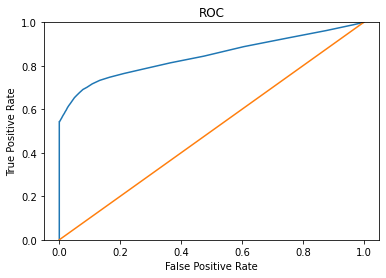

In [ ]:
pred_prob = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:
error_cutoff = pd.DataFrame({'cutoff': pd.Series(thresholds),
                             'class0_error(fpr)': pd.Series(fpr),
                             'class1_error(fnr)': 1 - pd.Series(tpr)})
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error(fnr)'] - error_cutoff['class0_error(fpr)']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error(fpr)  class1_error(fnr)  optimal_value
52    0.13            0.07769           0.308671       0.613639


In [ ]:
pdp_dict = {'Country': [],
            'Age': 'age',
            'Purchase Value': 'purchase_value',
            'Time to Purchase': 'time_to_purchase',
            'Unique IP': 'unique_ip',
            'Unique Device': 'unique_device',
            'Signup Day': 'signup_day',
            'Signup Week': 'signup_week',
            'Purchase Day': 'purchase_day',
            'Purchase Week': 'purchase_week',
            'Browser': [],
            'Source': [],
            'Sex': []}

for col in X_train.columns:
    if 'country' in col:
        pdp_dict['Country'].append(col)
    elif 'browser' in col:
        pdp_dict['Browser'].append(col)
    elif 'source' in col:
        pdp_dict['Source'].append(col)
    elif 'sex' in col:
        pdp_dict['Sex'].append(col)

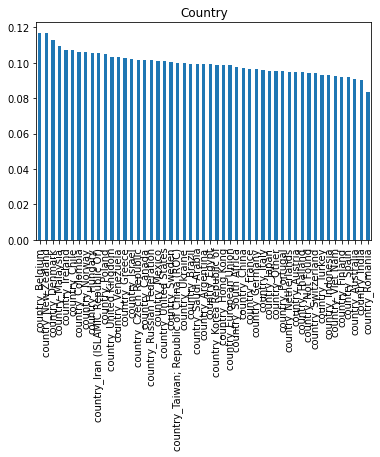

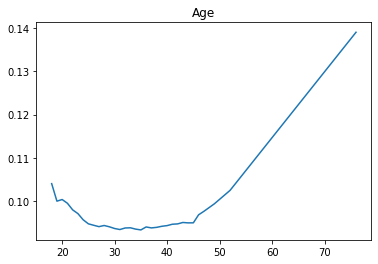

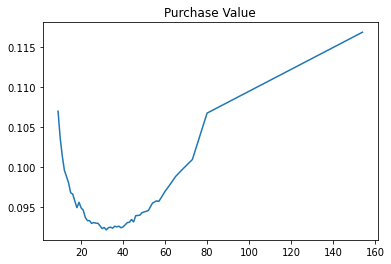

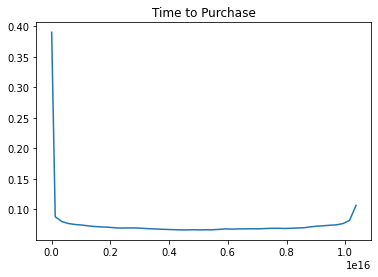

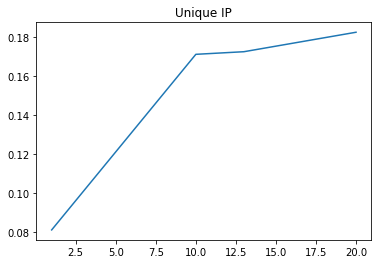

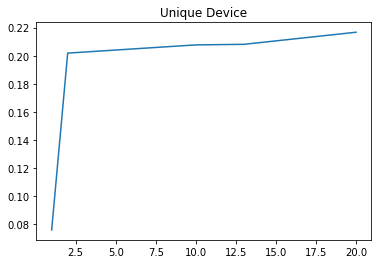

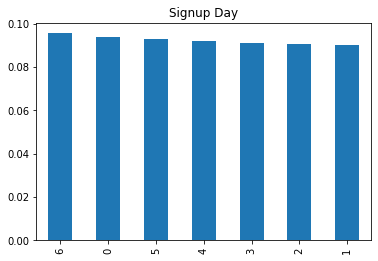

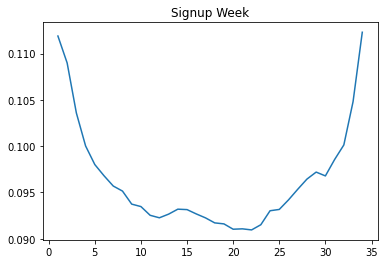

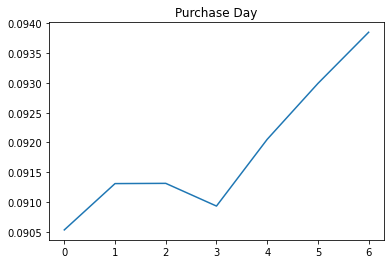

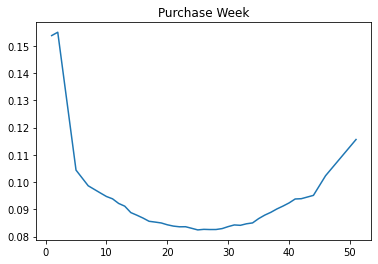

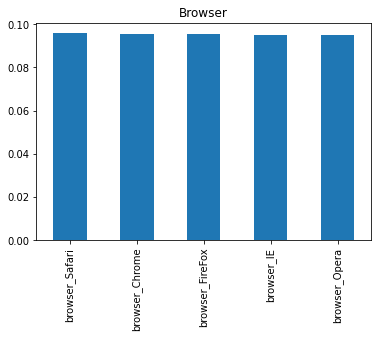

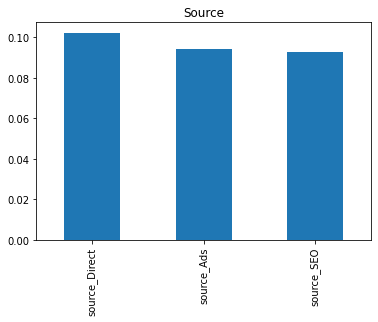

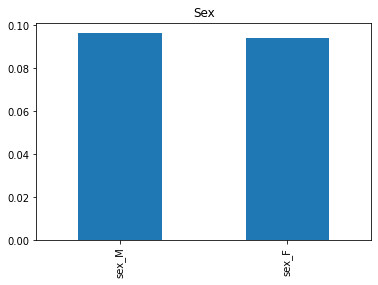

In [ ]:
# singles = ['Age', 'Purchase Value', 'Time to Purchase', 'Unique IP', 
#            'Unique Device', ' Signup Day', 'Signup Week', 
#            'Purchase Day', 'Purchase Week']

# for key, value in pdp_dict.items():
#     pdp_iso = pdp.pdp_isolate(
#                 model=rf_model, 
#                 dataset=X_train,      
#                 model_features=list(X_train), 
#                 feature=pdp_dict[key], 
#                 num_grid_points=50)
#     if key in singles:
#         pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
#         pdp_dataset.plot(title=key)
#     else:
#         pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
#         pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=key)
#     plt.show()

<a name='Explanation'></a>
# Explanation of the Model's Descision Process

<a name='Production'></a>
# Using the Model in Production

<a name='Conclusion'></a>
# Conclusion